In [1]:
# necessary libraries

from pmdarima.datasets import load_airpassengers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from arch.unitroot import ADF, KPSS
from pmdarima import auto_arima
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from merlion.models.utils.autosarima_utils import nsdiffs
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Creating a DataFrame with monthly air passenger data
data_monthly = pd.DataFrame(load_airpassengers(as_series=True), columns=["Number of Passengers"], dtype=int)

# Generating date range from January 1995 with monthly frequency
date = pd.date_range("01-01-1995", periods=len(data_monthly), freq="M")

# Adding a 'Month' column to the DataFrame and setting it as the index
data_monthly["Month"] = date
data_monthly.set_index("Month", inplace=True)

# Displaying the modified DataFrame
data_monthly

,Number of Passengers
Month,
1995-01-31,112
1995-02-28,118
1995-03-31,132
1995-04-30,129
1995-05-31,121
...,...
2006-08-31,606
2006-09-30,508
2006-10-31,461


In [5]:
# Displaying information about the DataFrame
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1995-01-31 to 2006-12-31
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Number of Passengers  144 non-null    int32
dtypes: int32(1)
memory usage: 1.7 KB


In [7]:
# Checking for missing values and summing them up
data_monthly.isnull().sum()

Number of Passengers    0
dtype: int64

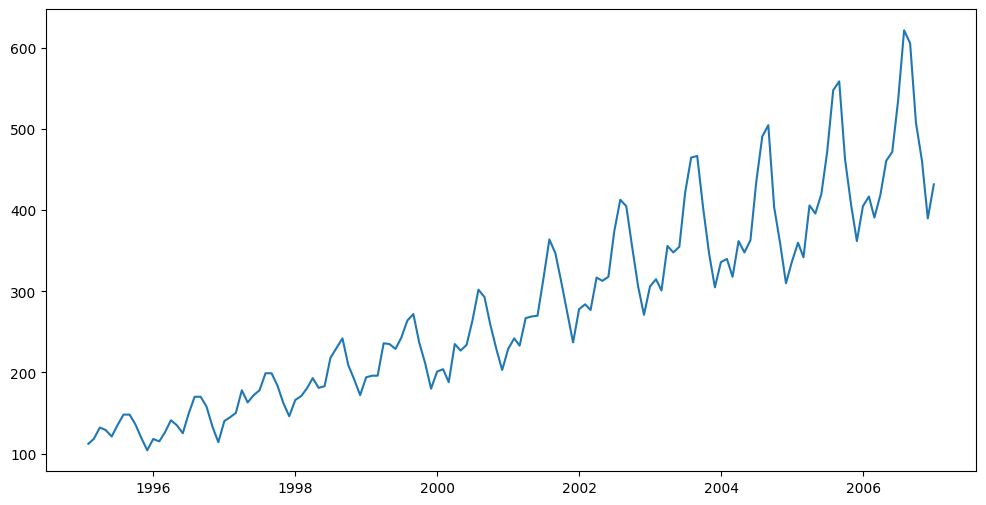

In [8]:
# Plotting the monthly air passenger data
plt.figure(figsize=(12,6))
plt.plot(data_monthly)
plt.show()

In [9]:
# Resampling the monthly data to quarterly and annual frequencies
data_quarter = data_monthly.resample("Q").sum()
data_anual = data_monthly.resample("A").sum()

# Printing the original monthly data, quarterly data, and annual data
print("Monthly Data:")
print(data_monthly)
print("\nQuarterly Data:")
print(data_quarter)
print("\nAnnual Data:")
print(data_anual)


Monthly Data:
            Number of Passengers
Month                           
1995-01-31                   112
1995-02-28                   118
1995-03-31                   132
1995-04-30                   129
1995-05-31                   121
...                          ...
2006-08-31                   606
2006-09-30                   508
2006-10-31                   461
2006-11-30                   390
2006-12-31                   432

[144 rows x 1 columns]

Quarterly Data:
            Number of Passengers
Month                           
1995-03-31                   362
1995-06-30                   385
1995-09-30                   432
1995-12-31                   341
1996-03-31                   382
1996-06-30                   409
1996-09-30                   498
1996-12-31                   387
1997-03-31                   473
1997-06-30                   513
1997-09-30                   582
1997-12-31                   474
1998-03-31                   544
1998-06-30           

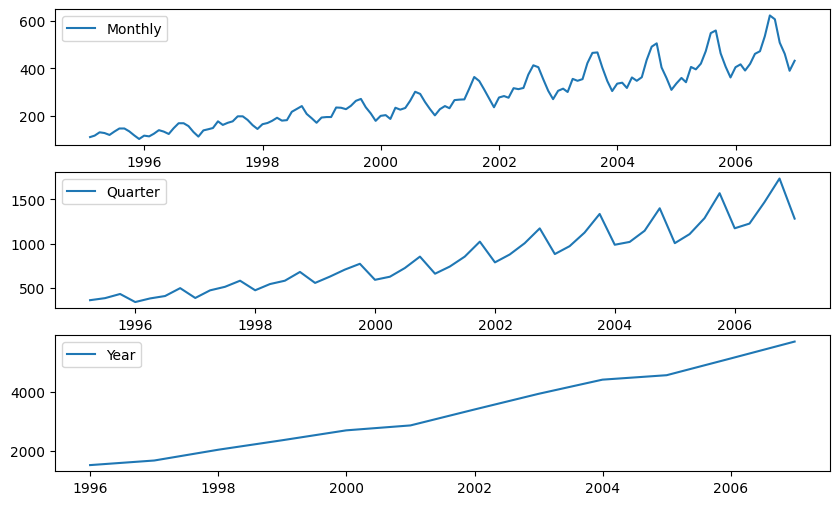

In [10]:
# Creating subplots for monthly, quarterly, and annual data
fig, ax = plt.subplots(3, 1, figsize=(10, 6))

# Plotting monthly data
ax[0].plot(data_monthly, label="Monthly")
ax[0].legend(loc=0)

# Plotting quarterly data
ax[1].plot(data_quarter, label="Quarter")
ax[1].legend(loc=0)

# Plotting annual data
ax[2].plot(data_anual, label="Year")
ax[2].legend(loc=0)

plt.show()

In [11]:
# Creating descriptive statistics for monthly, quarterly, and annual data
statistic1 = data_monthly.describe().T
statistic2 = data_quarter.describe().T
statistic3 = data_anual.describe().T

# Concatenating descriptive statistics into a single DataFrame
descriptive_statistics = pd.concat([statistic1, statistic2, statistic3])

# Defining index labels for the concatenated DataFrame
index_labels = ["Monthly Number of Passengers", "Number of Passengers per Quarter", "Annual Number of Passengers"]

# Setting index labels for the concatenated DataFrame
descriptive_statistics.index = index_labels

# Displaying the descriptive statistics
descriptive_statistics

,count,mean,std,min,25%,50%,75%,max
Monthly Number of Passengers,144.0,280.298611,119.966317,104.0,180.00,265.5,360.50,622.0
Number of Passengers per Quarter,48.0,840.895833,356.431441,341.0,553.75,781.0,1112.25,1736.0
Annual Number of Passengers,12.0,3363.583333,1390.585780,1520.0,2283.50,3137.5,4458.75,5714.0


In [12]:
# Adding a 'Months' column to the DataFrame, representing the months of the index
data_monthly["Months"] = data_monthly.index.month

# Adding a 'Years' column to the DataFrame, representing the years of the index
data_monthly["Years"] = data_monthly.index.year

# Displaying the modified DataFrame
data_monthly

,Number of Passengers,Months,Years
Month,,,
1995-01-31,112,1,1995
1995-02-28,118,2,1995
1995-03-31,132,3,1995
1995-04-30,129,4,1995
1995-05-31,121,5,1995
...,...,...,...
2006-08-31,606,8,2006
2006-09-30,508,9,2006
2006-10-31,461,10,2006


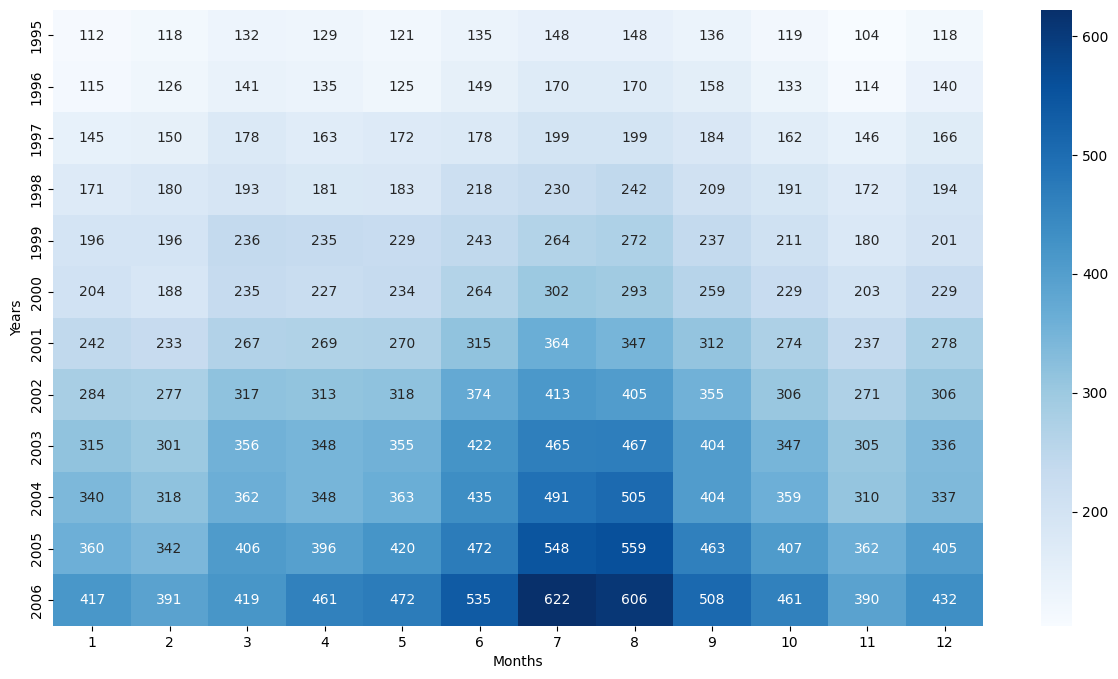

In [14]:
# Creating a figure for the heatmap plot with specified size
plt.figure(figsize=(15,8))

# Creating a pivot table from the monthly data to prepare for heatmap plotting
matrix = pd.pivot_table(data_monthly, values="Number of Passengers", index="Years", columns="Months")

# Generating a color palette for the heatmap
colors = sns.color_palette("Blues", as_cmap=True)

# Plotting the heatmap with seaborn
sns.heatmap(matrix, annot=True, fmt="g", cmap=colors)

# Displaying the heatmap plot
plt.show()


In [15]:
# Adding a 'Months' column to the DataFrame representing the months of the index
data_quarter["Months"] = data_quarter.index.month

# Adding a 'Years' column to the DataFrame representing the years of the index
data_quarter["Years"] = data_quarter.index.year

# Displaying the modified DataFrame
data_quarter.head()

,Number of Passengers,Months,Years
Month,,,
1995-03-31,362,3,1995
1995-06-30,385,6,1995
1995-09-30,432,9,1995
1995-12-31,341,12,1995
1996-03-31,382,3,1996
1996-06-30,409,6,1996
1996-09-30,498,9,1996
1996-12-31,387,12,1996
1997-03-31,473,3,1997


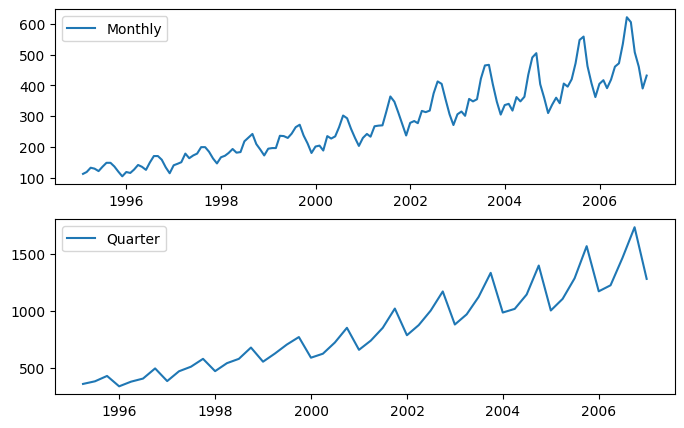

In [16]:
# Creating subplots for monthly and quarterly data
fig, ax = plt.subplots(2, 1, figsize=(8, 5))

# Plotting monthly data
ax[0].plot(data_monthly["Number of Passengers"], label="Monthly")
ax[0].legend(loc=0)

# Plotting quarterly data
ax[1].plot(data_quarter["Number of Passengers"], label="Quarter")
ax[1].legend(loc=0)

# Displaying the plots
plt.show()

In [17]:
# Applying Box-Cox transformation to the monthly data
data_monthly_boxcox, lm_monthly = boxcox(data_monthly["Number of Passengers"])
# Applying Box-Cox transformation to the quarterly data
data_quarter_boxcox, lm_quarter = boxcox(data_quarter["Number of Passengers"])

# Adding a 'BoxCox' column to the monthly DataFrame with transformed data
data_monthly["BoxCox"] = data_monthly_boxcox
# Adding a 'BoxCox' column to the quarterly DataFrame with transformed data
data_quarter["BoxCox"] = data_quarter_boxcox

# Displaying the modified monthly DataFrame
data_monthly

,Number of Passengers,Months,Years,BoxCox
Month,,,,
1995-01-31,112,1,1995,6.827490
1995-02-28,118,2,1995,6.932822
1995-03-31,132,3,1995,7.161892
1995-04-30,129,4,1995,7.114611
1995-05-31,121,5,1995,6.983787
...,...,...,...,...
2006-08-31,606,8,2006,10.684049
2006-09-30,508,9,2006,10.234573
2006-10-31,461,10,2006,9.992159


In [18]:
# Displaying the first few rows of the quarterly DataFrame
data_quarter.head()

,Number of Passengers,Months,Years,BoxCox
Month,,,,
1995-03-31,362,3,1995,10.115587
1995-06-30,385,6,1995,10.283682
1995-09-30,432,9,1995,10.602746
1995-12-31,341,12,1995,9.954175
1996-03-31,382,3,1996,10.262238


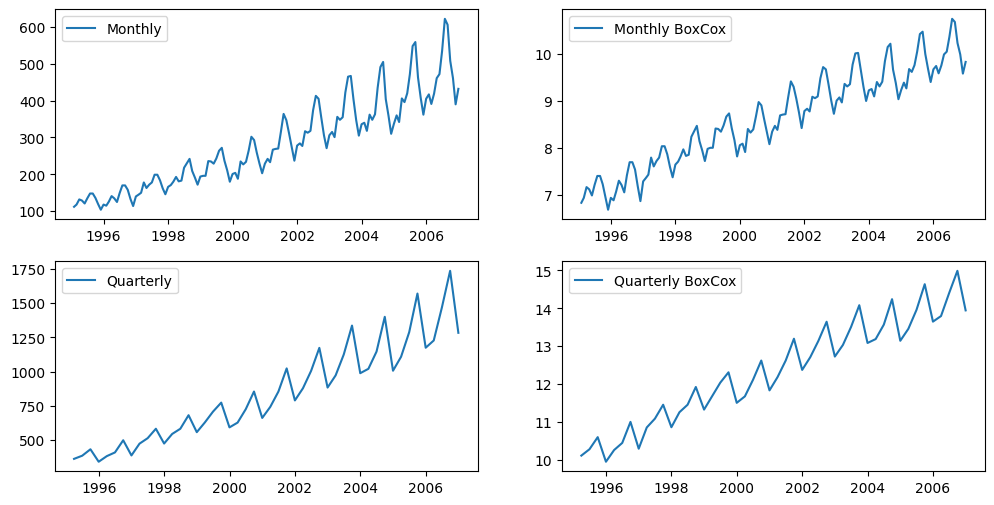

In [19]:
# Creating subplots for monthly and quarterly data
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# Plotting monthly data
ax[0, 0].plot(data_monthly["Number of Passengers"], label="Monthly")
ax[0, 0].legend(loc=0)

# Plotting monthly data with Box-Cox transformation
ax[0, 1].plot(data_monthly["BoxCox"], label="Monthly BoxCox")
ax[0, 1].legend(loc=0)

# Plotting quarterly data
ax[1, 0].plot(data_quarter["Number of Passengers"], label="Quarterly")
ax[1, 0].legend(loc=0)

# Plotting quarterly data with Box-Cox transformation
ax[1, 1].plot(data_quarter["BoxCox"], label="Quarterly BoxCox")
ax[1, 1].legend(loc=0)

# Displaying the plots
plt.show()

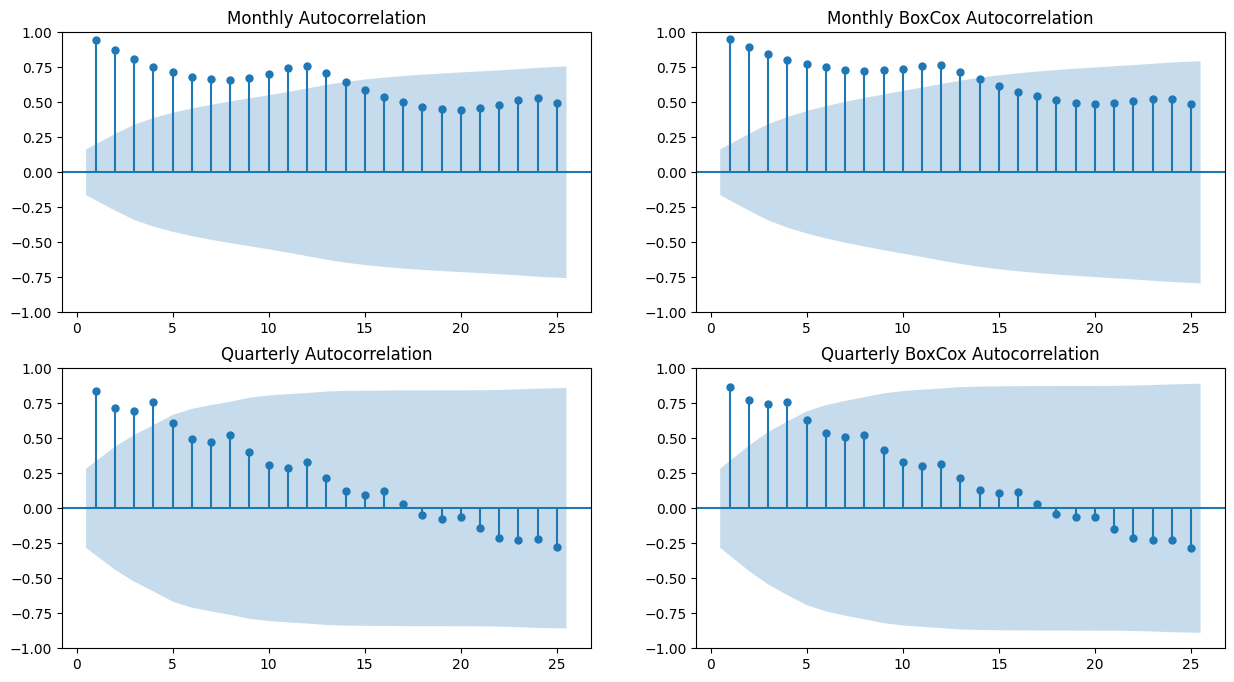

In [21]:
# Creating subplots for autocorrelation plots
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# Plotting autocorrelation for monthly data
plot_acf(data_monthly["Number of Passengers"], lags=25, zero=False, ax=ax[0, 0])
ax[0, 0].set_title("Monthly Autocorrelation")

# Plotting autocorrelation for monthly data with Box-Cox transformation
plot_acf(data_monthly["BoxCox"], lags=25, zero=False, ax=ax[0, 1])
ax[0, 1].set_title("Monthly BoxCox Autocorrelation")

# Plotting autocorrelation for quarterly data
plot_acf(data_quarter["Number of Passengers"], lags=25, zero=False, ax=ax[1, 0])
ax[1, 0].set_title("Quarterly Autocorrelation")

# Plotting autocorrelation for quarterly data with Box-Cox transformation
plot_acf(data_quarter["BoxCox"], lags=25, zero=False, ax=ax[1, 1])
ax[1, 1].set_title("Quarterly BoxCox Autocorrelation")

# Displaying the plots
plt.show()

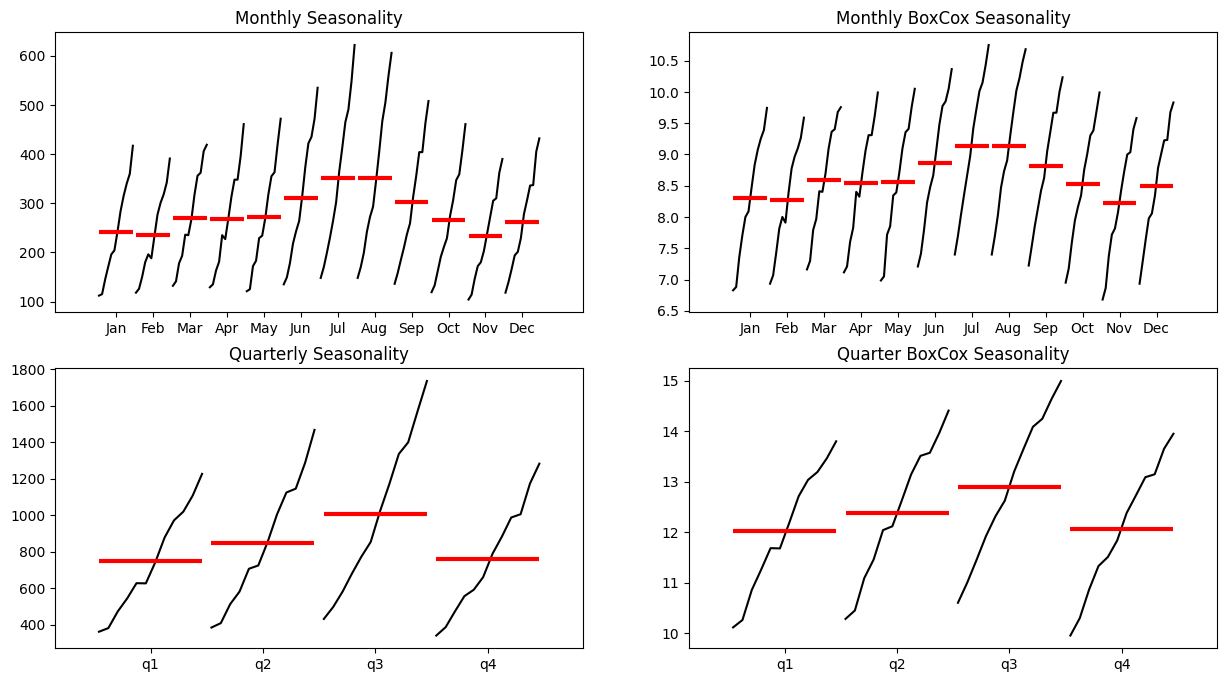

In [23]:
# Creating subplots for seasonal plots
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# Plotting monthly seasonality
month_plot(data_monthly["Number of Passengers"], ax=ax[0, 0])
ax[0, 0].set_title("Monthly Seasonality")

# Plotting monthly seasonality with Box-Cox transformation
month_plot(data_monthly["BoxCox"], ax=ax[0, 1])
ax[0, 1].set_title("Monthly BoxCox Seasonality")

# Plotting quarterly seasonality
quarter_plot(data_quarter["Number of Passengers"], ax=ax[1, 0])
ax[1, 0].set_title("Quarterly Seasonality")

# Plotting quarterly seasonality with Box-Cox transformation
quarter_plot(data_quarter["BoxCox"], ax=ax[1, 1])
ax[1, 1].set_title("Quarter BoxCox Seasonality")

# Displaying the plots
plt.show()

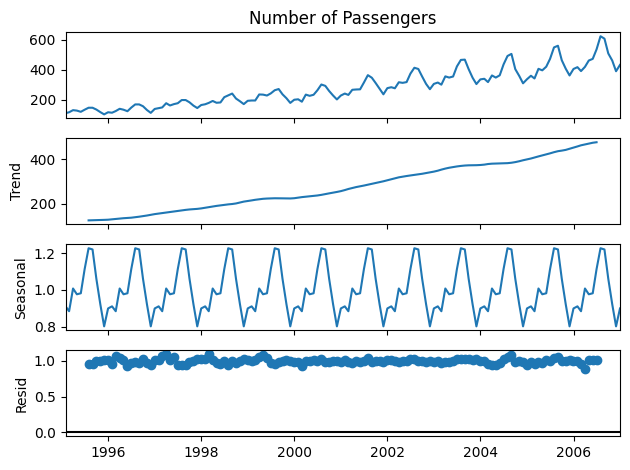

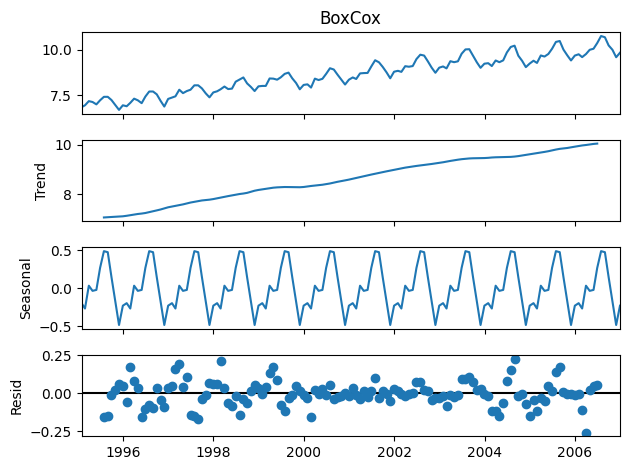

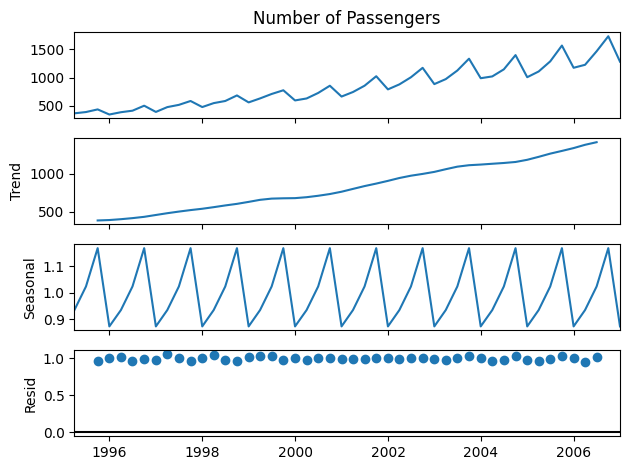

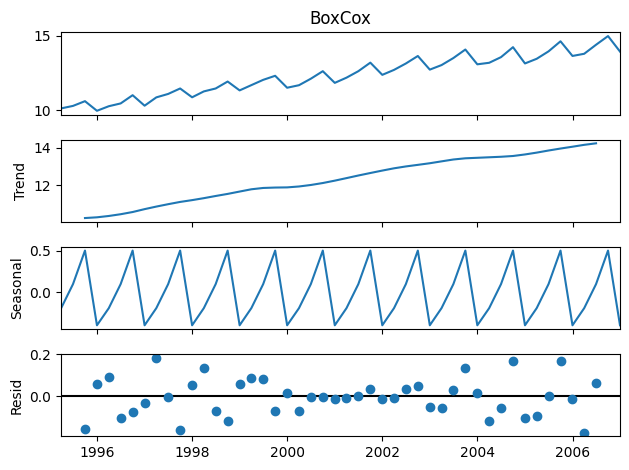

In [25]:
# Decomposing monthly data without Box-Cox transformation
sd_monthly = seasonal_decompose(data_monthly["Number of Passengers"], model="multiplicative", period=12)
sd_monthly.plot()

# Decomposing monthly data with Box-Cox transformation
sd_monthly_boxcox = seasonal_decompose(data_monthly["BoxCox"], model="additive", period=12)
sd_monthly_boxcox.plot()

# Decomposing quarterly data without Box-Cox transformation
sd_quarter = seasonal_decompose(data_quarter["Number of Passengers"], model="multiplicative", period=4)
sd_quarter.plot()

# Decomposing quarterly data with Box-Cox transformation
sd_quarter_boxcox = seasonal_decompose(data_quarter["BoxCox"], model="additive", period=4)
sd_quarter_boxcox.plot()

# Displaying the plots
plt.show()

In [27]:
# Extracting training data: all data except the last 12 months
data_train = data_monthly["Number of Passengers"].iloc[:-12]

# Extracting test data: the last 12 months
data_test = data_monthly["Number of Passengers"].iloc[-12:]

# Displaying the test data
data_test

Month
2006-01-31    417
2006-02-28    391
2006-03-31    419
2006-04-30    461
2006-05-31    472
2006-06-30    535
2006-07-31    622
2006-08-31    606
2006-09-30    508
2006-10-31    461
2006-11-30    390
2006-12-31    432
Name: Number of Passengers, dtype: int32

In [28]:
# Decomposing the training data into trend, seasonal, and residual components
sd = seasonal_decompose(data_train, model="multiplicative", period=12, extrapolate_trend="freq")

# Concatenating the decomposed components into a DataFrame
data = pd.concat(
    [sd.observed,
     sd.trend,
     sd.seasonal,
     sd.observed/sd.seasonal], axis=1)

# Renaming the columns for better interpretation
data.columns = ["Original Data", "Trend", "Seasonality", "Seasonal Adjustment"]

# Displaying the concatenated DataFrame
data

,Original Data,Trend,Seasonality,Seasonal Adjustment
Month,,,,
1995-01-31,112.0,118.588481,0.909983,123.079283
1995-02-28,118.0,119.734169,0.893216,132.106971
1995-03-31,132.0,120.879856,1.021380,129.236901
1995-04-30,129.0,122.025544,0.979458,131.705450
1995-05-31,121.0,123.171232,0.976657,123.892054
...,...,...,...,...
2005-08-31,559.0,430.219891,1.217181,459.257747
2005-09-30,463.0,434.019862,1.057779,437.709459
2005-10-31,407.0,437.819833,0.919291,442.732585


In [29]:
# Creating an array of index values from 1 to the length of the DataFrame
index_values = np.arange(1, len(data) + 1)

# Adding a new column 'T' with index values to the DataFrame
data["T"] = index_values

# Displaying the DataFrame with the new column
data

,Original Data,Trend,Seasonality,Seasonal Adjustment,T
Month,,,,,
1995-01-31,112.0,118.588481,0.909983,123.079283,1
1995-02-28,118.0,119.734169,0.893216,132.106971,2
1995-03-31,132.0,120.879856,1.021380,129.236901,3
1995-04-30,129.0,122.025544,0.979458,131.705450,4
1995-05-31,121.0,123.171232,0.976657,123.892054,5
...,...,...,...,...,...
2005-08-31,559.0,430.219891,1.217181,459.257747,128
2005-09-30,463.0,434.019862,1.057779,437.709459,129
2005-10-31,407.0,437.819833,0.919291,442.732585,130


In [30]:
# Adding a constant term to the predictor variable
x = sm.add_constant(data["T"])

# Selecting the response variable
y = data["Seasonal Adjustment"]

# Fitting a simple linear regression model
model_sm = sm.OLS(y, x).fit()

# Printing the summary of the regression model
print(model_sm.summary())

                             OLS Regression Results                            
Dep. Variable:     Seasonal Adjustment   R-squared:                       0.977
Model:                             OLS   Adj. R-squared:                  0.977
Method:                  Least Squares   F-statistic:                     5467.
Date:                 Wed, 07 Feb 2024   Prob (F-statistic):          4.34e-108
Time:                         16:17:28   Log-Likelihood:                -544.89
No. Observations:                  132   AIC:                             1094.
Df Residuals:                      130   BIC:                             1100.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.4167      2.649     34.89

In [31]:
# Converting the 'data_test' series to a DataFrame
data_test = pd.DataFrame(data_test)

# Adding the 'Seasonality' column from the 'data' DataFrame to 'data_test'
data_test["Seasonality"] = data["Seasonality"].iloc[:12].values

# Displaying the modified 'data_test' DataFrame
data_test

,Number of Passengers,Seasonality
Month,,
2006-01-31,417,0.909983
2006-02-28,391,0.893216
2006-03-31,419,1.021380
2006-04-30,461,0.979458
2006-05-31,472,0.976657
2006-06-30,535,1.105417
2006-07-31,622,1.223636
2006-08-31,606,1.217181
2006-09-30,508,1.057779


In [32]:
# Creating an array of index values for the test data, starting from the next index after the last index of the training data
entry = np.arange(len(data.index) + 1, len(data.index) + 13)

# Displaying the array
entry

array([133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144])

In [33]:
# Making predictions using the fitted linear regression model
pred_sm = model_sm.predict(sm.add_constant(entry))

# Adding the predictions to the test data DataFrame after adjusting for seasonality
data_test["Predictions"] = (data_test["Seasonality"] * pred_sm).astype(int)

# Displaying the modified test data DataFrame with predictions
data_test

,Number of Passengers,Seasonality,Predictions
Month,,,
2006-01-31,417,0.909983,393
2006-02-28,391,0.893216,388
2006-03-31,419,1.021380,446
2006-04-30,461,0.979458,430
2006-05-31,472,0.976657,432
2006-06-30,535,1.105417,491
2006-07-31,622,1.223636,547
2006-08-31,606,1.217181,547
2006-09-30,508,1.057779,478


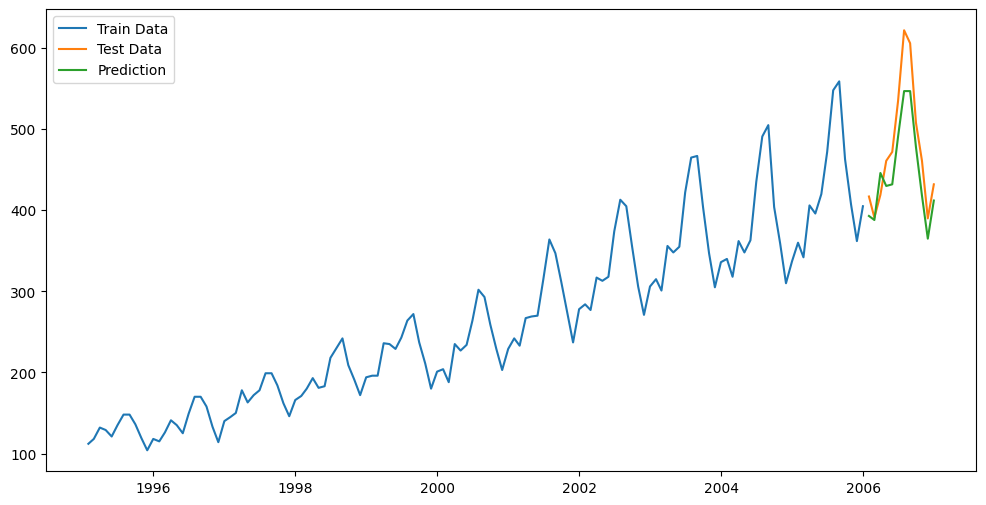

In [45]:
# Plotting the original training data, test data, and predictions
plt.figure(figsize=(12,6))
plt.plot(data["Original Data"], label="Train Data")
plt.plot(data_test["Number of Passengers"], label="Test Data")
plt.plot(data_test["Predictions"], label="Prediction")

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

In [36]:
def error(y, pred):
    # Calculating and printing Mean Squared Error (MSE)
    print("MSE: {}".format(mean_squared_error(y, pred)))
    # Calculating and printing Root Mean Squared Error (RMSE)
    print("RMSE: {}".format(np.sqrt(mean_squared_error(y, pred))))
    # Calculating and printing Mean Absolute Error (MAE)
    print("MAE: {}".format(mean_absolute_error(y, pred)))

In [38]:
# Calculating and printing the errors between the test data and predictions
error(data_test["Number of Passengers"], data_test["Predictions"])

MSE: 1557.5833333333333
RMSE: 39.466230290380324
MAE: 35.083333333333336


In [40]:
# Defining trend and seasonal types
trend_type = ["add", "mul"]
seasonal_type = ["add", "mul"]

# Looping through each combination of trend and seasonal types
for i in trend_type:
    for j in seasonal_type:
        # Fitting Holt-Winters Exponential Smoothing model
        holtwinter_model = ExponentialSmoothing(data_train, trend=i, seasonal=j, seasonal_periods=12).fit(optimized=True)
        # Forecasting for the next 12 periods
        pred_holtwinter = holtwinter_model.forecast(12)
        # Calculating RMSE
        rmse = np.sqrt(mean_squared_error(data_test["Number of Passengers"], pred_holtwinter))
        # Printing the trend, seasonal type, and RMSE
        print("Trend: {}, Seasonality: {}, RMSE: {}".format(i, j, rmse))

Trend: add, Seasonality: add, RMSE: 16.979906128442913
Trend: add, Seasonality: mul, RMSE: 15.807367605699495
Trend: mul, Seasonality: add, RMSE: 16.513615846250456
Trend: mul, Seasonality: mul, RMSE: 25.810226318474683


In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fitting Holt-Winters Exponential Smoothing model with specified trend and seasonal types
holtwinter_model = ExponentialSmoothing(data_train, trend="add", seasonal="multiplicative", seasonal_periods=12).fit(optimized=True)

# Forecasting for the next 12 periods
pred_holtwinter = holtwinter_model.forecast(12)

# Calculating RMSE
holtwinter_rmse = np.sqrt(mean_squared_error(data_test["Number of Passengers"], pred_holtwinter))

# Printing the RMSE
print("RMSE:", holtwinter_rmse)

RMSE: 15.807367605699495


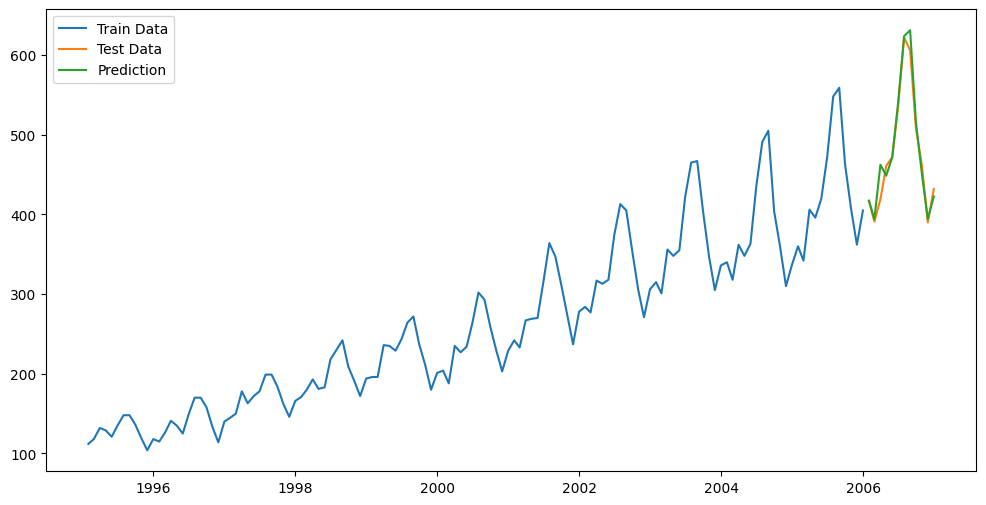

In [46]:
# Creating a figure for the plot with specified size
plt.figure(figsize=(12,6))

# Plotting the training data
plt.plot(data_train, label="Train Data")

# Plotting the test data
plt.plot(data_test["Number of Passengers"], label="Test Data")

# Plotting the predictions
plt.plot(pred_holtwinter, label="Prediction")

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

In [47]:
# Converting the 'data_train' series to a DataFrame
data_train = pd.DataFrame(data_train)

# Displaying the DataFrame
data_train

,Number of Passengers
Month,
1995-01-31,112
1995-02-28,118
1995-03-31,132
1995-04-30,129
1995-05-31,121
...,...
2005-08-31,559
2005-09-30,463
2005-10-31,407


In [49]:
# Performing the Augmented Dickey-Fuller test on the training data with constant and linear trend
adf = ADF(data_train.squeeze(), trend='ct')

# Printing the results of the ADF test
print(adf)

# Printing the summary of the regression results
print(adf.regression.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.040
P-value                         0.579
Lags                               13
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     82.86
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           4.83e-50
Time:                        16:27:53   Log-Likelihood:                -426.83
No. Observations:                 118   AIC:                             885.7
Df Residuals:                     102   BIC:            

In [51]:
# Performing the KPSS test on the training data with constant and linear trend
kpss_test = KPSS(data_train.squeeze(), trend='ct')

# Printing the results of the KPSS test
print(kpss_test)

    KPSS Stationarity Test Results   
Test Statistic                  0.088
P-value                         0.219
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [52]:
# Determining the number of seasonal differences using the Canova-Hansen test
ch = nsdiffs(data_train["Number of Passengers"], m=12, test="ch")

# Determining the number of seasonal differences using the OCSB test
ocbs = nsdiffs(data_train["Number of Passengers"], m=12, test="ocbs")

# Printing the results
print("ch:", ch)
print("ocbs:", ocbs)

ch: 0
ocbs: 0


In [53]:
# Displaying the data
data

,Original Data,Trend,Seasonality,Seasonal Adjustment,T
Month,,,,,
1995-01-31,112.0,118.588481,0.909983,123.079283,1
1995-02-28,118.0,119.734169,0.893216,132.106971,2
1995-03-31,132.0,120.879856,1.021380,129.236901,3
1995-04-30,129.0,122.025544,0.979458,131.705450,4
1995-05-31,121.0,123.171232,0.976657,123.892054,5
...,...,...,...,...,...
2005-08-31,559.0,430.219891,1.217181,459.257747,128
2005-09-30,463.0,434.019862,1.057779,437.709459,129
2005-10-31,407.0,437.819833,0.919291,442.732585,130


In [55]:
# Performing the Augmented Dickey-Fuller test on the 'Seasonal Adjustment' data with constant and linear trend
adf = ADF(data["Seasonal Adjustment"], trend='ct')

# Performing the KPSS test on the 'Seasonal Adjustment' data with constant and linear trend
kpss = KPSS(data["Seasonal Adjustment"], trend='ct')

# Printing the results of the Augmented Dickey-Fuller test
print(adf)

# Printing the results of the KPSS test
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.863
P-value                         0.673
Lags                                8
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.282
P-value                         0.002
Lags                                6
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [57]:
# seasonality

# Fit an AutoARIMA model to the training data with seasonal component
auto_arima_model_1 = auto_arima(data_train["Number of Passengers"], trace=False, seasonal=True, m=12)

# Make predictions using the AutoARIMA model for the next 12 periods
pred_auto_arima_1 = auto_arima_model_1.predict(12)

# Calculate the Root Mean Squared Error (RMSE) of the AutoARIMA model
auto_arima_rmse_1 = np.sqrt(mean_squared_error(data_test["Number of Passengers"], pred_auto_arima_1))

# Print the RMSE of the AutoARIMA model
print("First AutoARIMA Model's RMSE:", auto_arima_rmse_1)


First AutoARIMA Model's RMSE: 18.536469014046745


In [58]:
# Displaying the data
data

,Original Data,Trend,Seasonality,Seasonal Adjustment,T
Month,,,,,
1995-01-31,112.0,118.588481,0.909983,123.079283,1
1995-02-28,118.0,119.734169,0.893216,132.106971,2
1995-03-31,132.0,120.879856,1.021380,129.236901,3
1995-04-30,129.0,122.025544,0.979458,131.705450,4
1995-05-31,121.0,123.171232,0.976657,123.892054,5
...,...,...,...,...,...
2005-08-31,559.0,430.219891,1.217181,459.257747,128
2005-09-30,463.0,434.019862,1.057779,437.709459,129
2005-10-31,407.0,437.819833,0.919291,442.732585,130


In [59]:
# Displaying the test data
data_test

,Number of Passengers,Seasonality,Predictions
Month,,,
2006-01-31,417,0.909983,393
2006-02-28,391,0.893216,388
2006-03-31,419,1.021380,446
2006-04-30,461,0.979458,430
2006-05-31,472,0.976657,432
2006-06-30,535,1.105417,491
2006-07-31,622,1.223636,547
2006-08-31,606,1.217181,547
2006-09-30,508,1.057779,478


In [60]:
# de-seasonalize

# Fit an AutoARIMA model to the 'Seasonal Adjustment' data without considering seasonality
auto_arima_model_2 = auto_arima(data["Seasonal Adjustment"], trace=False, seasonal=False)

# Make predictions using the AutoARIMA model for the next 12 periods
pred_auto_arima_2 = auto_arima_model_2.predict(12)

# De-seasonalize the predictions by multiplying them with the 'Seasonality' data of the test set
pred_auto_arima_2 = pred_auto_arima_2 * data_test["Seasonality"]

# Calculate the Root Mean Squared Error (RMSE) of the de-seasonalized AutoARIMA model
auto_arima_rmse_2 = np.sqrt(mean_squared_error(data_test["Number of Passengers"], pred_auto_arima_2))

# Print the RMSE of the de-seasonalized AutoARIMA model
print("Second (de-seasonalize) AutoARIMA Model's RMSE:", auto_arima_rmse_2)


Second (de-seasonalize) AutoARIMA Model's RMSE: 26.382803940318876


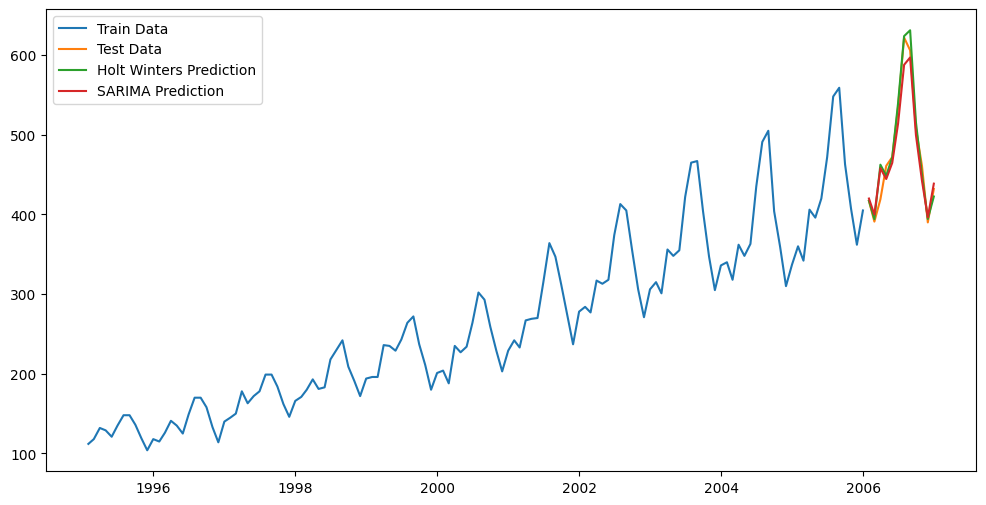

In [61]:
# Creating a figure for the plot with specified size
plt.figure(figsize=(12,6))

# Plotting the training data
plt.plot(data_train["Number of Passengers"], label="Train Data")

# Plotting the test data
plt.plot(data_test["Number of Passengers"], label="Test Data")

# Plotting the predictions from Holt-Winters model
plt.plot(pred_holtwinter, label="Holt Winters Prediction")

# Plotting the predictions from SARIMA model
plt.plot(pred_auto_arima_1, label="SARIMA Prediction")

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# We find out the best model for this data set is Holt Winters